# Perform submodular optimization to identify portfolio

## Import modules

In [123]:
import openml
import numpy as np
import json
import pandas as pd
import importlib
import sklearn
import string
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from utils import functions_best_setups
from utils.functions_best_setups import sub_opt, perf_imp
from plotnine import *

importlib.reload(functions_best_setups)


# set api key
openml.config.apikey = open('.key', 'r').readline().strip('\n')

In [2]:
sklearn.__version__

'0.21.2'

## Get HGB evaluation matrix

In [3]:
# get HGB evals
evals_hgb = openml.evaluations.list_evaluations('area_under_roc_curve', 
                                            uploader = [8323], 
                                            flow=[12736],
                                            output_format='dataframe')

evals_hgb.shape

(35708, 14)

In [43]:
# drop runs with insufficient number of evals on CC-18
ids = (evals_hgb.setup_id.value_counts()).index[(evals_hgb.setup_id.value_counts() >= 50)]
evals_subset_hgb = evals_hgb[evals_hgb.setup_id.isin(ids)]

# transform to wide format
evals_wide_hgb = evals_subset_hgb.pivot_table(index = 'setup_id', 
                                      columns = 'task_id', 
                                      values = 'value')


In [44]:
evals_wide_hgb = evals_wide_hgb.drop([3573, 146825, 167124], axis = 1)
evals_wide_hgb


task_id,3,6,11,12,14,15,16,18,22,23,...,146819,146820,146821,146822,146824,167119,167120,167125,167140,167141
setup_id,,,,,,,,,,,,,,,,,,,,,
8153766,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
8153768,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
8153789,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
8153791,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
8153802,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8168895,0.840000,0.500021,0.500546,0.500000,0.500000,0.644844,0.500000,0.500000,0.500000,0.505050,...,0.520221,0.500000,0.499851,0.500000,0.500000,0.500006,0.514574,0.500218,0.500272,0.813266
8168910,0.999597,0.999704,0.980430,0.998846,0.983405,0.990940,0.998489,0.954767,0.971019,0.707143,...,0.939711,0.989274,1.000000,0.994930,0.998962,0.974505,0.521389,0.980906,0.994357,0.928592
8168921,0.999661,0.999729,0.967361,0.998572,0.983552,0.990841,0.998274,0.947665,0.955634,0.695659,...,0.942308,0.989258,0.999990,0.995286,0.998738,0.981950,0.517092,0.978584,0.994514,0.922842


## Get SVC evaluation matrix

### Get evaluations

In [6]:
# get SVC evals
evals_svc = openml.evaluations.list_evaluations('area_under_roc_curve', 
                                            uploader = [8323], 
                                            flow=[16374, 16347, 16345, 16366, 18298, 17494],
                                            output_format='dataframe')

evals_svc = evals_svc[evals_svc.upload_time>'2019-11-16 22:50:39']

In [7]:
# get evals of mixed tasks and other tasks with unmatched setup ids
mixed_tasks = [23, 29, 31, 219, 2079, 3021, 3022, 7592, 9971, 9977, 14954, 
               14965, 125920, 167125, 167141, 3, 45, 49, 3560, 14952, 
               146195, 146821, 167125, 167140, 3573]
evals_mixed_svc = evals_svc[evals_svc.task_id.isin(mixed_tasks)]
evals_mixed_svc.shape
len(evals_mixed_svc.setup_id.unique())

3523

In [8]:
# get evals of pure tasks
evals_pure_svc = evals_svc[~evals_svc.task_id.isin(mixed_tasks)]
evals_pure_svc.shape
len(evals_pure_svc.setup_id.unique())

605

### Get setups

In [9]:
# get setups of mixed tasks
setup_info_names = list(evals_mixed_svc.columns)
param_names = ['C', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape',
               'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state',
               'shrinking', 'tol', 'verbose']

setups_mixed = pd.DataFrame(columns = setup_info_names+param_names)

for i in evals_mixed_svc.iterrows():
    setup_model = openml.setups.initialize_model(i[1].setup_id)
    params = setup_model.steps[2][1].get_params().values()
    setups_mixed.loc[len(setups_mixed)] = list(i[1])+list(params)

In [10]:
# get setups of pure tasks
setups_pure = pd.DataFrame(columns = ['setup_id']+param_names)

for i in evals_pure_svc.setup_id.unique():
    setup_model = openml.setups.initialize_model(i)
    params = setup_model.steps[2][1].get_params().values()
    setups_pure.loc[len(setups_pure)] = [i]+list(params)


### Match and reassign setups to correct setup_ids

In [11]:
# match setup_ids
param_keys = ['C', 'coef0', 'degree', 'gamma', 'kernel', 'max_iter']

setups_matches = setups_mixed.merge(setups_pure, how='inner', on=param_keys)
setups_matches.rename(columns={'setup_id_y':'setup_id'}, inplace=True)

In [12]:
evals_mixed_final = setups_matches

### Recreate evaluation matrix with matched setups

In [13]:
# merge pure and mixed setups
evals_svc = evals_pure_svc.append(evals_mixed_final)

In [39]:
# drop runs with insufficient number of evals on CC-18
ids = (evals_svc.setup_id.value_counts()).index[(evals_svc.setup_id.value_counts() >= 50)]
evals_subset_svc = evals_svc[evals_svc.setup_id.isin(ids)]

# transform to wide format
evals_wide_svc = evals_subset_svc.pivot_table(index = 'setup_id', 
                                      columns = 'task_id', 
                                      values = 'value')

In [40]:
evals_wide_svc

task_id,3,6,11,12,14,15,16,18,22,23,...,146817,146819,146820,146821,146822,146824,167119,167120,167140,167141
setup_id,,,,,,,,,,,,,,,,,,,,,
8255509,0.979148,0.989495,0.981979,0.999275,0.980622,0.994573,0.998110,NaN,NaN,0.693388,...,0.902443,0.952077,0.991964,0.979154,0.974699,0.999370,NaN,NaN,0.993549,0.880809
8255510,0.986995,0.993091,0.980991,0.999125,0.982386,0.994972,0.997976,0.960343,NaN,0.682877,...,0.902759,0.949613,0.985389,0.987057,0.980924,0.998829,NaN,NaN,0.990846,0.883022
8255513,0.990997,0.995431,0.987158,0.999425,0.981152,0.994582,0.999211,0.958083,NaN,0.721782,...,0.915162,0.949503,0.992449,0.982903,0.980378,0.999548,NaN,NaN,0.994394,0.887175
8255514,0.989217,0.993589,0.981123,0.999137,0.981871,0.994981,0.997771,0.961297,NaN,0.682734,...,0.903286,0.952561,0.985148,0.983359,0.981547,0.998824,NaN,NaN,0.989646,0.882811
8255515,0.990898,0.993967,0.980819,0.999133,0.981384,0.994664,0.997771,0.963189,0.987134,0.684902,...,0.904582,0.949701,0.984356,0.986549,0.982286,0.998807,0.847415,NaN,0.988417,0.881865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8255930,0.998374,0.998572,0.992071,0.999228,0.982837,0.994392,0.998137,0.967326,0.988779,0.736100,...,0.922060,0.944332,0.992861,0.993915,0.987913,0.999171,0.892124,NaN,0.988297,0.902140
8255938,0.990832,0.994135,0.980422,0.999124,0.981244,0.995053,0.997768,0.966006,0.986707,0.684563,...,0.904997,0.952781,0.978551,0.987186,0.983655,0.998746,0.785172,NaN,0.984533,0.581293
8255939,0.991260,0.997457,0.953448,0.493664,0.489772,0.977631,0.497107,0.963570,0.538000,0.577637,...,0.875179,0.430228,0.960503,0.996390,0.988708,0.495350,0.898225,NaN,0.615992,0.412310


# Get RF evaluation matrix

### Get evaluations

In [16]:
# get SVC evals
evals_rf = openml.evaluations.list_evaluations('area_under_roc_curve', 
                                            uploader = [8323], 
                                            flow=[8351, 17651, 17652, 17653,17654, 17655,
                                                  17656, 17657, 17658, 17691, 17692],
                                            output_format='dataframe')

evals_rf = evals_rf[evals_rf.upload_time>'2020-01-01 22:50:39']

In [17]:
# get evals of mixed tasks and other tasks with unmatched setup ids
mixed_tasks = [23, 29, 31, 219, 2079, 3021, 3022, 7592, 9971, 9977, 14954, 
               14965, 125920, 167125, 167141, 3, 45, 49, 3560, 14952, 146195, 
               146821, 167125, 167140, 3573]
evals_mixed_rf = evals_rf[evals_rf.task_id.isin(mixed_tasks)]
evals_mixed_rf.shape
len(evals_mixed_rf.setup_id.unique())

3175

In [18]:
# get evals of pure tasks
#ids = (evals_svc.setup_id.value_counts()).index[(evals_svc.setup_id.value_counts() >= 19)]
evals_pure_rf = evals_rf[~evals_rf.task_id.isin(mixed_tasks)]
evals_pure_rf.shape
len(evals_pure_rf.setup_id.unique())

466

### Get setups

In [19]:
# get setups of mixed tasks
setup_info_names = list(evals_mixed_rf.columns)
param_names = ['bootstrap', 'class_weight', 'criterion', 'max_depth', 
               'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 
               'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 
               'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 
               'oob_score', 'random_state', 'verbose', 'warm_start']

setups_mixed = pd.DataFrame(columns = setup_info_names+param_names)

for i in evals_mixed_rf.iterrows():
    try:
        setup_model = openml.setups.initialize_model(i[1].setup_id)
        params = setup_model.steps[2][1].get_params().values()
        setups_mixed.loc[len(setups_mixed)] = list(i[1])+list(params)
    except Exception as e:
        print(e)

Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.

Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.


In [20]:
# get setups of pure tasks
setup_info_names = ['setup_id']
setups_pure = pd.DataFrame(columns = setup_info_names+param_names)

for i in evals_pure_rf.setup_id.unique():
    try:
        setup_model = openml.setups.initialize_model(i)
        params = setup_model.steps[2][1].get_params().values()
        setups_pure.loc[len(setups_pure)] = [i]+list(params)
    except Exception as e:
        print(e)


Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.

Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.

### Match and reassign setups to correct setup_ids

In [21]:
# match setup_ids
param_keys = ['max_depth', 'max_features', 'max_leaf_nodes',
               'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 
               'min_weight_fraction_leaf', 'n_estimators']

setups_matches = setups_mixed.merge(setups_pure, how='inner', on=param_keys)
setups_matches.rename(columns={'setup_id_y':'setup_id'}, inplace=True)

In [22]:
evals_mixed_final = setups_matches

### Recreate evaluation matrix with matched setups

In [23]:
# merge pure and mixed setups
evals_rf = evals_pure_rf.append(evals_mixed_final)

In [41]:
# drop runs with insufficient number of evals on CC-18
ids = (evals_rf.setup_id.value_counts()).index[(evals_rf.setup_id.value_counts() >= 50)]
evals_subset_rf = evals_rf[evals_rf.setup_id.isin(ids)]

# transform to wide format
evals_wide_rf = evals_subset_rf.pivot_table(index = 'setup_id', 
                                      columns = 'task_id', 
                                      values = 'value')

In [42]:
evals_wide_rf

task_id,3,6,11,12,14,15,16,18,22,23,...,146817,146819,146820,146821,146822,146824,167119,167120,167140,167141
setup_id,,,,,,,,,,,,,,,,,,,,,
8261487,0.998087,0.995934,0.926366,0.995869,0.967540,0.987860,0.987469,0.935913,0.938442,0.678605,...,0.918474,0.813237,0.964502,0.993580,0.992057,0.994838,0.909935,0.506147,0.984075,0.906524
8261494,0.999845,0.999605,0.921634,0.998238,0.983050,0.991555,0.997632,0.956512,0.957962,0.709890,...,0.946693,0.906547,0.987845,0.999170,0.995108,0.998649,0.947693,NaN,0.990398,0.912012
8261509,0.999400,0.999539,0.926493,0.998437,0.984318,0.992743,0.998242,0.959687,0.969771,0.716755,...,0.941658,0.911151,0.987178,0.998174,0.995802,0.999036,0.941555,0.518011,0.992909,0.913303
8261514,0.999863,0.999620,0.919052,0.998051,0.983242,0.992553,0.997474,0.954910,0.952303,0.705385,...,0.945893,0.918364,0.983701,0.999236,0.995714,0.998801,0.947017,0.514251,0.991344,0.909095
8261516,0.989970,0.929470,0.940218,0.996920,0.974587,0.988621,0.993379,0.956808,0.964933,0.673004,...,0.891836,0.911063,0.498101,0.936902,0.986532,0.995837,0.828700,0.499967,0.991569,0.854782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8262202,0.980597,0.995831,0.941459,0.995919,0.963724,0.991257,0.991264,0.959298,0.967827,0.702721,...,0.915645,0.893505,0.986524,0.989442,0.990501,0.993985,0.948118,0.526063,0.981142,0.891179
8262208,0.999260,0.998245,0.949219,0.997886,0.981075,0.992788,0.994922,0.960218,0.968115,0.727327,...,0.945015,0.928578,0.992292,0.997315,0.994450,0.996282,0.964662,0.516366,0.988140,0.917167
8262236,0.998926,0.999322,0.921400,0.998683,0.983361,0.993359,0.998033,0.956499,0.962872,0.674099,...,0.936250,0.891084,0.987149,0.996676,0.995704,0.999172,0.933631,0.519800,0.993847,0.914274


# Get LR evaluation matrix

### Get evaluations

In [26]:
# get LR evals
evals_lr = openml.evaluations.list_evaluations('area_under_roc_curve', 
                                            uploader = [8323], 
                                            flow=[18600, 18601, 18602, 18607, 18608, 18591],
                                            output_format='dataframe')

evals_lr = evals_lr[evals_lr.upload_time>'2020-01-01 22:50:39']

In [27]:
evals_lr.flow_id.unique()

array([18591, 18601, 18607, 18608])

In [28]:
# get evals of mixed tasks and other tasks with unmatched setup ids
mixed_tasks = [23, 29, 31, 219, 2079, 3021, 3022, 7592, 9971, 9977, 14954, 
               14965, 125920, 167125, 167141, 3, 45, 49, 3560, 14952, 146195, 
               146821, 167125, 167140, 3573]
evals_mixed_lr = evals_lr[evals_lr.task_id.isin(mixed_tasks)]
evals_mixed_lr.shape
len(evals_mixed_lr.setup_id.unique())

336

In [29]:
# get evals of pure tasks
#ids = (evals_svc.setup_id.value_counts()).index[(evals_svc.setup_id.value_counts() >= 19)]
evals_pure_lr = evals_lr[~evals_lr.task_id.isin(mixed_tasks)]
evals_pure_lr.shape
len(evals_pure_lr.setup_id.unique())

41

### Get setups

In [30]:
# get setups of mixed tasks
setup_info_names = list(evals_mixed_lr.columns)
param_names = ['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling',
               'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state',
               'solver', 'tol', 'verbose', 'warm_start']

setups_mixed = pd.DataFrame(columns = setup_info_names+param_names)

for i in evals_mixed_lr.iterrows():
    try:
        setup_model = openml.setups.initialize_model(i[1].setup_id)
        params = setup_model.steps[2][1].get_params().values()
        setups_mixed.loc[len(setups_mixed)] = list(i[1])+list(params)
    except Exception as e:
        print(e)

In [31]:
# get setups of pure tasks
setup_info_names = ['setup_id']
setups_pure = pd.DataFrame(columns = setup_info_names+param_names)

for i in evals_pure_lr.setup_id.unique():
    try:
        setup_model = openml.setups.initialize_model(i)
        params = setup_model.steps[2][1].get_params().values()
        setups_pure.loc[len(setups_pure)] = [i]+list(params)
    except Exception as e:
        print(e)


### Match and reassign setups to correct setup_ids

In [32]:
# match setup_ids
param_keys = ['C', 'class_weight', 'fit_intercept', 'intercept_scaling',
               'l1_ratio', 'max_iter', 'multi_class', 'penalty', 'solver']

setups_matches = setups_mixed.merge(setups_pure, how='inner', on=param_keys)
setups_matches.rename(columns={'setup_id_y':'setup_id'}, inplace=True)

In [33]:
evals_mixed_final = setups_matches

### Recreate evaluation matrix with matched setups

In [34]:
# merge pure and mixed setups
evals_lr = evals_pure_lr.append(evals_mixed_final)

In [45]:
# drop runs with insufficient number of evals on CC-18
ids = (evals_lr.setup_id.value_counts()).index[(evals_lr.setup_id.value_counts() >= 50)]
evals_subset_lr = evals_lr[evals_lr.setup_id.isin(ids)]

# transform to wide format
evals_wide_lr = evals_subset_lr.pivot_table(index = 'setup_id', 
                                      columns = 'task_id', 
                                      values = 'value')

In [46]:
evals_wide_lr

task_id,3,6,11,12,14,15,16,18,22,23,...,146817,146819,146820,146821,146822,146824,167119,167120,167140,167141
setup_id,,,,,,,,,,,,,,,,,,,,,
8275573,0.993711,0.966406,0.964313,0.997582,0.974706,0.994655,0.993201,0.959767,0.977864,0.696013,...,0.888107,0.952209,0.977024,0.982291,0.973050,0.991818,0.807317,0.530294,0.990422,0.860150
8275574,0.947720,0.943182,0.938496,0.993962,0.955194,0.993785,0.986600,0.909544,0.954943,0.681521,...,0.840252,0.938347,0.737693,0.962881,0.943102,0.992894,0.807767,0.530211,0.984452,0.714376
8275575,0.980171,0.961852,0.943416,0.996304,0.970395,0.994347,0.992442,0.947947,0.971636,0.691344,...,0.872369,0.949173,0.787248,0.965363,0.963652,0.994329,0.807388,0.530304,0.990911,0.788766
8275614,0.993711,0.966406,0.964313,0.997582,0.974706,0.994655,0.993201,0.959767,0.977864,0.696013,...,0.888107,0.952209,0.977024,0.982291,0.973050,0.991818,0.807317,0.530294,0.990422,0.860150
8275615,0.980171,0.961852,0.943416,0.996304,0.970395,0.994347,0.992442,0.947947,0.971636,0.691344,...,0.872369,0.949173,0.787248,0.965363,0.963652,0.994329,0.807388,0.530304,0.990911,0.788766
8275616,0.994996,0.966684,0.971378,0.997290,0.973594,0.994383,0.992427,0.960695,0.978681,0.696009,...,0.891911,0.949657,0.977658,0.984561,0.976143,0.992959,0.807314,0.530296,0.988750,0.860220
8275617,0.993711,0.966406,0.964313,0.997582,0.974706,0.994655,0.993201,0.959767,0.977864,0.696013,...,0.888107,0.952209,0.977024,0.982291,0.973050,0.991818,0.807317,0.530294,0.990422,0.860150
8275618,0.947720,0.943182,0.938496,0.993962,0.955194,0.993785,0.986600,0.909544,0.954943,0.681521,...,0.840252,0.938347,0.737693,0.962881,0.943102,0.992894,0.807767,0.530211,0.984452,0.714376
8275619,0.993702,0.966684,0.964107,0.997419,0.975262,0.994673,0.993364,0.960179,0.978308,0.695982,...,0.890151,0.951945,0.976909,0.982317,0.974268,0.993578,0.807314,0.530296,0.990440,0.860119


## Merge HGB, SVC and RF data 

In [47]:
evals_wide_merged = pd.concat([evals_wide_hgb, evals_wide_svc, evals_wide_rf, evals_wide_lr], join='inner')
evals_wide_merged

task_id,3,6,11,12,14,15,16,18,22,23,...,146817,146819,146820,146821,146822,146824,167119,167120,167140,167141
setup_id,,,,,,,,,,,,,,,,,,,,,
8153766,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.952229,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.994517,0.923335
8153768,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.952229,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.994517,0.923335
8153789,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.952229,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.994517,0.923335
8153791,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.952229,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.994517,0.923335
8153802,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.952229,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.994517,0.923335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8275917,0.980230,0.954636,0.942219,0.995694,0.965261,0.994283,0.989819,0.923099,0.967534,0.690592,...,0.862183,0.948645,0.823595,0.966957,0.958569,0.990381,0.807630,0.530303,0.990686,0.801283
8275918,0.995514,0.966684,0.972244,0.997125,0.971288,0.994347,0.990538,0.959885,0.977461,0.695993,...,0.892321,0.949437,0.977496,0.984954,0.977630,0.992407,0.807313,0.530295,0.985348,0.860037
8275919,0.995320,0.966672,0.971926,0.997493,0.973425,0.994338,0.992263,0.960497,0.978697,0.696013,...,0.891999,0.949833,0.977622,0.984788,0.976307,0.990691,0.807314,0.530294,0.987721,0.860066


In [48]:
evals_wide_svc = evals_wide_merged.loc[evals_wide_svc.index,:]

# empty list for indices of missing values
missing = []

for i in evals_wide_svc.columns:
    for j in evals_wide_svc.index:
        
        coordinates = (j, i)
        
        value = evals_wide_svc.at[coordinates]

        if np.isnan(value):
            missing.append(coordinates)
            
missing = pd.DataFrame(missing, columns=['setup_id', 'task_id'])
missing.to_csv('svc_missing.csv')
missing.groupby('task_id').count()

evals_wide_svc.isna().sum().sum() / np.prod(evals_wide_svc.shape)

0.08681754251374504

In [49]:
evals_wide_rf = evals_wide_merged.loc[evals_wide_rf.index,:]

# empty list for indices of missing values
missing = []

for i in evals_wide_rf.columns:
    for j in evals_wide_rf.index:
        
        coordinates = (j, i)
        
        value = evals_wide_rf.at[coordinates]

        if np.isnan(value):
            missing.append(coordinates)
            
missing = pd.DataFrame(missing, columns=['setup_id', 'task_id'])
missing.to_csv('rf_missing.csv')
missing.groupby('task_id').setup_id.count()

evals_wide_rf.isna().sum().sum() / np.prod(evals_wide_rf.shape)

0.03567937438905181

In [50]:
evals_wide_lr = evals_wide_merged.loc[evals_wide_lr.index,:]

# empty list for indices of missing values
missing = []

for i in evals_wide_lr.columns:
    for j in evals_wide_lr.index:
        
        coordinates = (j, i)
        
        value = evals_wide_lr.at[coordinates]

        if np.isnan(value):
            missing.append(coordinates)
            
missing = pd.DataFrame(missing, columns=['setup_id', 'task_id'])
missing.to_csv('lr_missing.csv')
missing.groupby('task_id').setup_id.count()

evals_wide_lr.isna().sum().sum() / np.prod(evals_wide_lr.shape)

0.0

## Clean merged data

In [51]:
evals_wide_merged[evals_wide_merged < 0.5] = np.nan

## Standardize merged data

In [52]:
evals_wide_merged.loc[len(evals_wide_merged)] = 0.5

evals_merged_std = pd.DataFrame(MinMaxScaler().fit_transform(X = evals_wide_merged), 
                               index= evals_wide_merged.index,
                               columns = evals_wide_merged.columns)

evals_wide_merged = evals_wide_merged.drop(evals_wide_merged.index[-1], axis=0)
evals_merged_std = evals_merged_std.drop(evals_merged_std.index[-1], axis=0)
evals_merged_std = evals_merged_std.fillna(0)

In [53]:
evals_svc_std = evals_merged_std.loc[evals_wide_svc.index,:]
evals_hgb_std = evals_merged_std.loc[evals_wide_hgb.index,:]
evals_rf_std = evals_merged_std.loc[evals_wide_rf.index,:]
evals_lr_std = evals_merged_std.loc[evals_wide_lr.index,:]

## Rank merged data

In [54]:
evals_merged_rank = evals_merged_std.rank(method='max')

evals_merged_rank = pd.DataFrame(MinMaxScaler().fit_transform(X = evals_merged_rank), 
                               index = evals_merged_rank.index,
                               columns = evals_merged_rank.columns)

evals_svc_rank = evals_merged_rank.loc[evals_wide_svc.index,:]
evals_hgb_rank = evals_merged_rank.loc[evals_wide_hgb.index,:]
evals_rf_rank = evals_merged_rank.loc[evals_wide_rf.index,:]
evals_lr_rank = evals_merged_rank.loc[evals_wide_lr.index,:]

In [55]:
evals_merged_rank

task_id,3,6,11,12,14,15,16,18,22,23,...,146817,146819,146820,146821,146822,146824,167119,167120,167140,167141
setup_id,,,,,,,,,,,,,,,,,,,,,
8153766,0.815545,0.911972,0.499418,0.703797,0.797724,0.504046,0.772327,0.382685,0.315722,0.602594,...,0.968009,0.693607,0.707674,0.879187,0.873775,0.706186,0.844078,0.658163,0.867612,0.882915
8153768,0.815545,0.911972,0.499418,0.703797,0.797724,0.504046,0.772327,0.382685,0.315722,0.602594,...,0.968009,0.693607,0.707674,0.879187,0.873775,0.706186,0.844078,0.658163,0.867612,0.882915
8153789,0.815545,0.911972,0.499418,0.703797,0.797724,0.504046,0.772327,0.382685,0.315722,0.602594,...,0.968009,0.693607,0.707674,0.879187,0.873775,0.706186,0.844078,0.658163,0.867612,0.882915
8153791,0.815545,0.911972,0.499418,0.703797,0.797724,0.504046,0.772327,0.382685,0.315722,0.602594,...,0.968009,0.693607,0.707674,0.879187,0.873775,0.706186,0.844078,0.658163,0.867612,0.882915
8153802,0.815545,0.911972,0.499418,0.703797,0.797724,0.504046,0.772327,0.382685,0.315722,0.602594,...,0.968009,0.693607,0.707674,0.879187,0.873775,0.706186,0.844078,0.658163,0.867612,0.882915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8275917,0.104408,0.120892,0.288708,0.081013,0.091024,0.865896,0.095597,0.067754,0.364691,0.316038,...,0.080569,0.811821,0.053593,0.088517,0.062500,0.083763,0.139430,0.989796,0.332151,0.123059
8275918,0.277262,0.154930,0.534342,0.118987,0.137800,0.883237,0.106918,0.597240,0.774485,0.389151,...,0.155213,0.837153,0.158343,0.187799,0.147059,0.109536,0.095952,0.974490,0.191489,0.200717
8275919,0.266821,0.142019,0.526193,0.170886,0.171934,0.869364,0.120755,0.644918,0.800258,0.402123,...,0.145735,0.872135,0.172960,0.181818,0.132353,0.086340,0.113943,0.945578,0.229314,0.203106


In [56]:
evals_merged_rank.describe()

task_id,3,6,11,12,14,15,16,18,22,23,...,146817,146819,146820,146821,146822,146824,167119,167120,167140,167141
count,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,...,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000,867.000000
mean,0.497886,0.491997,0.496115,0.456323,0.456823,0.499977,0.459182,0.460316,0.448165,0.489758,...,0.487373,0.479066,0.474197,0.486127,0.471243,0.448289,0.385401,0.339771,0.488589,0.483422
std,0.290518,0.293729,0.291444,0.310488,0.310191,0.289740,0.309259,0.308706,0.313425,0.294865,...,0.296205,0.300741,0.302673,0.303697,0.304065,0.313503,0.329796,0.333856,0.295546,0.298123
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.246520,0.237676,0.243888,0.177848,0.178887,0.249711,0.183019,0.185069,0.163015,0.234080,...,0.230450,0.216526,0.208892,0.223086,0.204044,0.163015,0.026237,0.000000,0.232270,0.224014
50%,0.497680,0.491784,0.499418,0.451899,0.452592,0.504046,0.455346,0.456713,0.442010,0.489387,...,0.486967,0.477684,0.472594,0.482057,0.469363,0.442010,0.350825,0.263605,0.488180,0.482676
75%,0.748840,0.745892,0.747963,0.725949,0.726296,0.750289,0.727673,0.728984,0.721005,0.744693,...,0.743483,0.738842,0.736297,0.741029,0.734681,0.721005,0.675412,0.631803,0.744090,0.741338
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Submodular optimization AUC (min-max scaled, mean)

In [57]:
def eval_order(evals, order_id=False):
        
    if order_id==True:
        order_setups = np.argsort(evals.index)
        order_tasks = np.argsort(evals.columns)
        
    else:                 
        order_setups = np.argsort(evals.mean(axis = 1))
        order_tasks = np.argsort(evals.mean(axis = 0))
        
    evals_ordered = evals.iloc[order_setups, order_tasks]
    
    return evals_ordered

In [58]:
evals_wide_ordered = eval_order(evals_merged_rank)

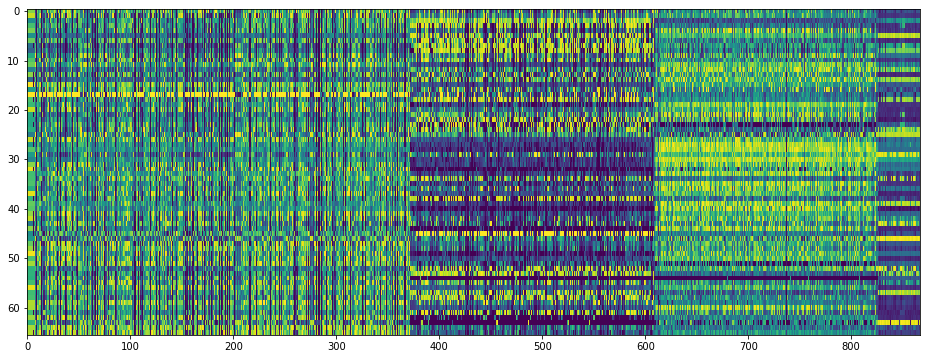

In [59]:
plt.figure(figsize = (16, 6))
plt.imshow(evals_merged_rank.T, aspect = 'auto')

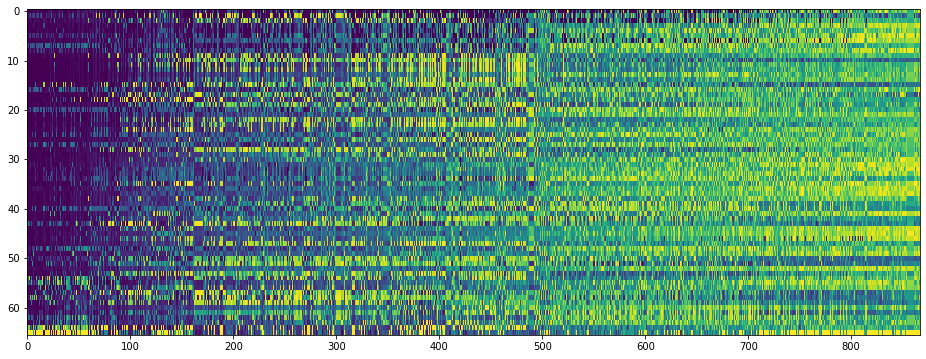

In [60]:
plt.figure(figsize = (16, 6))
plt.imshow(evals_wide_ordered.T, aspect = 'auto')

# Compare performance

## Standardized mean

In [61]:
setup_id, pp_merged_mean_std, pp_merged_sem_std = perf_imp(evals_merged_std, evals_merged_std, 
                                                           criterion='mean', ranking='min')
setup_id, pp_hgb_mean_std, pp_hgb_sem_std = perf_imp(evals_hgb_std, evals_hgb_std,
                                                    criterion='mean', ranking='min')
setup_id, pp_svc_mean_std, pp_svc_sem_std = perf_imp(evals_svc_std, evals_svc_std,
                                                    criterion='mean', ranking='min')
setup_id, pp_rf_mean_std, pp_rf_sem_std = perf_imp(evals_rf_std, evals_rf_std,
                                                  criterion='mean', ranking='min')
setup_id, pp_lr_mean_std, pp_lr_sem_std = perf_imp(evals_lr_std, evals_lr_std,
                                                  criterion='mean', ranking='min')

In [62]:
merged_std_u = [i + j for i, j in zip(pp_merged_mean_std[0:50], pp_merged_sem_std[0:50])]
merged_std_l = [i - j for i, j in zip(pp_merged_mean_std[0:50], pp_merged_sem_std[0:50])]
hgb_std_u = [i + j for i, j in zip(pp_hgb_mean_std[0:50], pp_hgb_sem_std[0:50])]
hgb_std_l = [i - j for i, j in zip(pp_hgb_mean_std[0:50], pp_hgb_sem_std[0:50])]
svc_std_u = [i + j for i, j in zip(pp_svc_mean_std[0:50], pp_svc_sem_std[0:50])]
svc_std_l = [i - j for i, j in zip(pp_svc_mean_std[0:50], pp_svc_sem_std[0:50])]
rf_std_u = [i + j for i, j in zip(pp_rf_mean_std[0:50], pp_rf_sem_std[0:50])]
rf_std_l = [i - j for i, j in zip(pp_rf_mean_std[0:50], pp_rf_sem_std[0:50])]
lr_std_u = [i + j for i, j in zip(pp_lr_mean_std[0:50], pp_lr_sem_std[0:50])]
lr_std_l = [i - j for i, j in zip(pp_lr_mean_std[0:50], pp_lr_sem_std[0:50])]

''

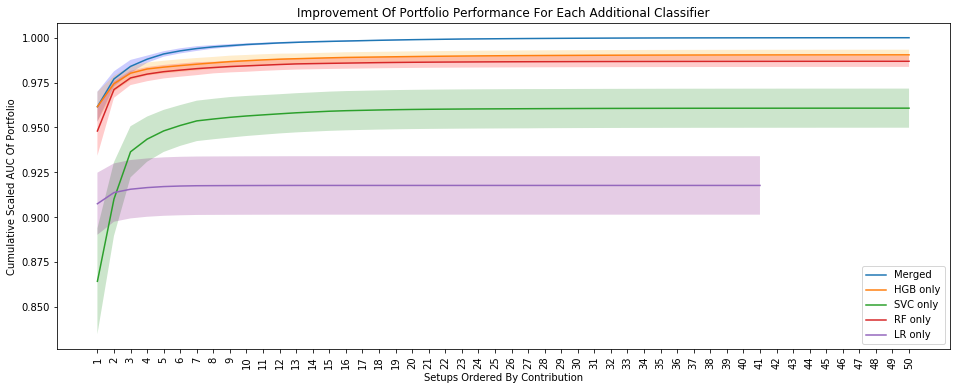

In [63]:
ax1 = pd.Series(pp_merged_mean_std[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_hgb_mean_std[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_svc_mean_std[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_rf_mean_std[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_lr_mean_std[0:50]).plot(figsize = (16,6), xticks=range(50))


ax1.fill_between(range(0,50), merged_std_u, merged_std_l, alpha=0.2, facecolor='blue')
ax1.fill_between(range(0,50), hgb_std_u, hgb_std_l, alpha=0.2, facecolor='orange')
ax1.fill_between(range(0,50), svc_std_u, svc_std_l, alpha=0.2, facecolor='green')
ax1.fill_between(range(0,50), rf_std_u, rf_std_l, alpha=0.2, facecolor='red')
ax1.fill_between(range(0,41), lr_std_u, lr_std_l, alpha=0.2, facecolor='purple')



ax1.set_xticklabels(labels=range(1,51), rotation = 90)
ax1.legend(['Merged','HGB only','SVC only', 'RF only', 'LR only'])
ax1.set_yscale('linear')
ax1.set_ylabel('Cumulative Scaled AUC Of Portfolio')
ax1.set_xlabel('Setups Ordered By Contribution')
ax1.set_title('Improvement Of Portfolio Performance For Each Additional Classifier')
;

''

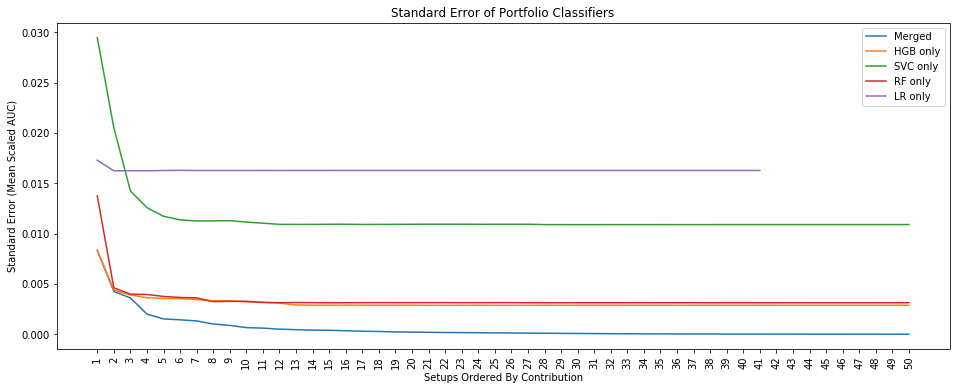

In [64]:
ax1 = pd.Series(pp_merged_sem_std[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_hgb_sem_std[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_svc_sem_std[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_rf_sem_std[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_lr_sem_std[0:50]).plot(figsize = (16,6), xticks=range(50))



ax1.set_xticklabels(labels=range(1,51), rotation = 90)
ax1.legend(['Merged','HGB only','SVC only', 'RF only', 'LR only'])
ax1.set_yscale('linear')
ax1.set_ylabel('Standard Error (Mean Scaled AUC)')
ax1.set_xlabel('Setups Ordered By Contribution')
ax1.set_title('Standard Error of Portfolio Classifiers')
;

## Ranked mean

In [65]:
setup_id, pp_merged_mean_rank, pp_merged_sem_rank = perf_imp(evals_merged_rank, evals_merged_rank,
                                                            criterion='mean', ranking='min')
setup_id, pp_hgb_mean_rank, pp_hgb_sem_rank = perf_imp(evals_hgb_rank, evals_hgb_rank,
                                                      criterion='mean', ranking='min')
setup_id, pp_svc_mean_rank, pp_svc_sem_rank = perf_imp(evals_svc_rank, evals_svc_rank,
                                                      criterion='mean', ranking='min')
setup_id, pp_rf_mean_rank, pp_rf_sem_rank = perf_imp(evals_rf_rank, evals_rf_rank,
                                                     criterion='mean', ranking='min')
setup_id, pp_lr_mean_rank, pp_lr_sem_rank = perf_imp(evals_lr_rank, evals_lr_rank,
                                                     criterion='mean', ranking='min')

In [66]:
merged_rank_u = [i + j for i, j in zip(pp_merged_mean_rank[0:50], pp_merged_sem_rank[0:50])]
merged_rank_l = [i - j for i, j in zip(pp_merged_mean_rank[0:50], pp_merged_sem_rank[0:50])]
hgb_rank_u = [i + j for i, j in zip(pp_hgb_mean_rank[0:50], pp_hgb_sem_rank[0:50])]
hgb_rank_l = [i - j for i, j in zip(pp_hgb_mean_rank[0:50], pp_hgb_sem_rank[0:50])]
svc_rank_u = [i + j for i, j in zip(pp_svc_mean_rank[0:50], pp_svc_sem_rank[0:50])]
svc_rank_l = [i - j for i, j in zip(pp_svc_mean_rank[0:50], pp_svc_sem_rank[0:50])]
rf_rank_u = [i + j for i, j in zip(pp_rf_mean_rank[0:50], pp_rf_sem_rank[0:50])]
rf_rank_l = [i - j for i, j in zip(pp_rf_mean_rank[0:50], pp_rf_sem_rank[0:50])]
lr_rank_u = [i + j for i, j in zip(pp_lr_mean_rank[0:50], pp_lr_sem_rank[0:50])]
lr_rank_l = [i - j for i, j in zip(pp_lr_mean_rank[0:50], pp_lr_sem_rank[0:50])]

''

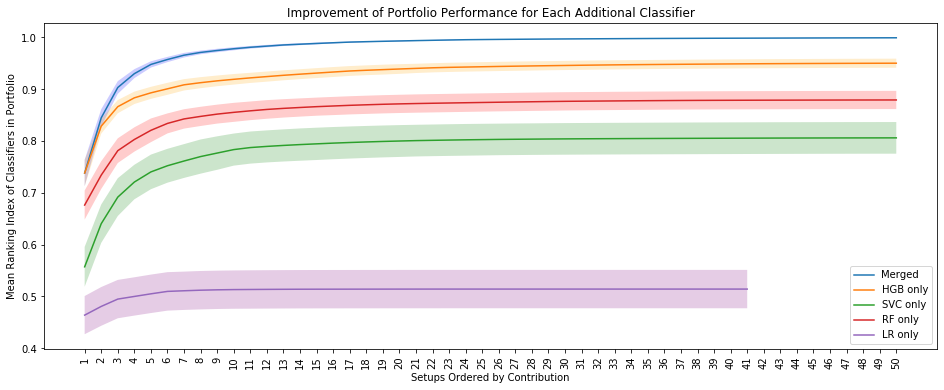

In [67]:
ax1 = pd.Series(pp_merged_mean_rank[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_hgb_mean_rank[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_svc_mean_rank[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_rf_mean_rank[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_lr_mean_rank[0:50]).plot(figsize = (16,6), xticks=range(50))


ax1.fill_between(range(0,50), merged_rank_u, merged_rank_l, alpha=0.2, facecolor='blue')
ax1.fill_between(range(0,50), hgb_rank_u, hgb_rank_l, alpha=0.2, facecolor='orange')
ax1.fill_between(range(0,50), svc_rank_u, svc_rank_l, alpha=0.2, facecolor='green')
ax1.fill_between(range(0,50), rf_rank_u, rf_rank_l, alpha=0.2, facecolor='red')
ax1.fill_between(range(0,41), lr_rank_u, lr_rank_l, alpha=0.2, facecolor='purple')



ax1.set_xticklabels(labels=range(1,51), rotation = 90)
ax1.legend(['Merged','HGB only','SVC only', 'RF only', 'LR only'])
ax1.set_yscale('linear')
ax1.set_ylabel('Mean Ranking Index of Classifiers in Portfolio')
ax1.set_xlabel('Setups Ordered by Contribution')
ax1.set_title('Improvement of Portfolio Performance for Each Additional Classifier')
;

''

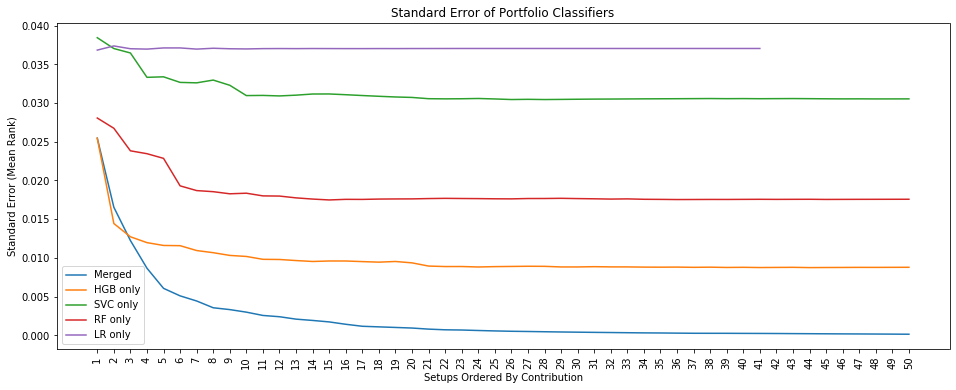

In [69]:
ax1 = pd.Series(pp_merged_sem_rank[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_hgb_sem_rank[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_svc_sem_rank[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_rf_sem_rank[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_lr_sem_rank[0:50]).plot(figsize = (16,6), xticks=range(50))



ax1.set_xticklabels(labels=range(1,51), rotation = 90)
ax1.legend(['Merged','HGB only','SVC only', 'RF only', 'LR only'])
ax1.set_yscale('linear')
ax1.set_ylabel('Standard Error (Mean Rank)')
ax1.set_xlabel('Setups Ordered By Contribution')
ax1.set_title('Standard Error of Portfolio Classifiers')
;

In [70]:
setup_id, pp_merged_mean_rank, pp_merged_sem_rank = perf_imp(evals_merged_rank, evals_merged_std,
                                                            criterion='mean', ranking='min')
setup_id, pp_hgb_mean_rank, pp_hgb_sem_rank = perf_imp(evals_hgb_rank, evals_hgb_std,
                                                      criterion='mean', ranking='min')
setup_id, pp_svc_mean_rank, pp_svc_sem_rank = perf_imp(evals_svc_rank, evals_svc_std,
                                                      criterion='mean', ranking='min')
setup_id, pp_rf_mean_rank, pp_rf_sem_rank = perf_imp(evals_rf_rank, evals_rf_std,
                                                     criterion='mean', ranking='min')
setup_id, pp_lr_mean_rank, pp_lr_sem_rank = perf_imp(evals_lr_rank, evals_lr_std,
                                                     criterion='mean', ranking='min')

''

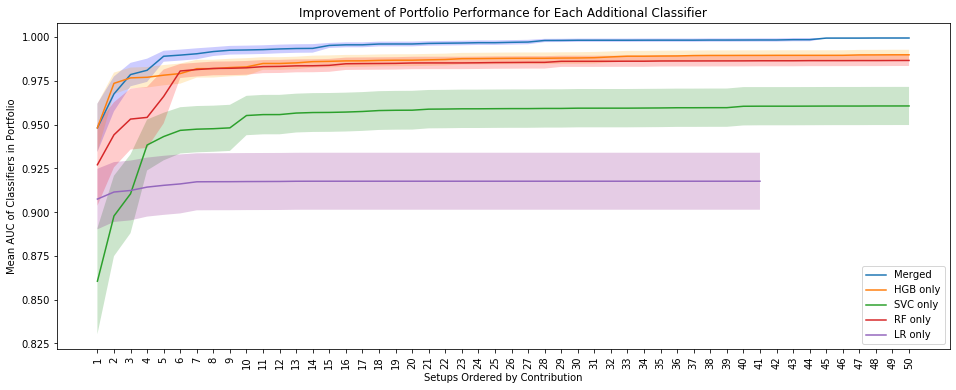

In [71]:
merged_rank_u = [i + j for i, j in zip(pp_merged_mean_rank[0:50], pp_merged_sem_rank[0:50])]
merged_rank_l = [i - j for i, j in zip(pp_merged_mean_rank[0:50], pp_merged_sem_rank[0:50])]
hgb_rank_u = [i + j for i, j in zip(pp_hgb_mean_rank[0:50], pp_hgb_sem_rank[0:50])]
hgb_rank_l = [i - j for i, j in zip(pp_hgb_mean_rank[0:50], pp_hgb_sem_rank[0:50])]
svc_rank_u = [i + j for i, j in zip(pp_svc_mean_rank[0:50], pp_svc_sem_rank[0:50])]
svc_rank_l = [i - j for i, j in zip(pp_svc_mean_rank[0:50], pp_svc_sem_rank[0:50])]
rf_rank_u = [i + j for i, j in zip(pp_rf_mean_rank[0:50], pp_rf_sem_rank[0:50])]
rf_rank_l = [i - j for i, j in zip(pp_rf_mean_rank[0:50], pp_rf_sem_rank[0:50])]
lr_rank_u = [i + j for i, j in zip(pp_lr_mean_rank[0:50], pp_lr_sem_rank[0:50])]
lr_rank_l = [i - j for i, j in zip(pp_lr_mean_rank[0:50], pp_lr_sem_rank[0:50])]

ax1 = pd.Series(pp_merged_mean_rank[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_hgb_mean_rank[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_svc_mean_rank[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_rf_mean_rank[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_lr_mean_rank[0:50]).plot(figsize = (16,6), xticks=range(50))


ax1.fill_between(range(0,50), merged_rank_u, merged_rank_l, alpha=0.2, facecolor='blue')
ax1.fill_between(range(0,50), hgb_rank_u, hgb_rank_l, alpha=0.2, facecolor='orange')
ax1.fill_between(range(0,50), svc_rank_u, svc_rank_l, alpha=0.2, facecolor='green')
ax1.fill_between(range(0,50), rf_rank_u, rf_rank_l, alpha=0.2, facecolor='red')
ax1.fill_between(range(0,41), lr_rank_u, lr_rank_l, alpha=0.2, facecolor='purple')


ax1.set_xticklabels(labels=range(1,51), rotation = 90)
ax1.legend(['Merged','HGB only','SVC only', 'RF only', 'LR only'])
ax1.set_yscale('linear')
ax1.set_ylabel('Mean AUC of Classifiers in Portfolio')
ax1.set_xlabel('Setups Ordered by Contribution')
ax1.set_title('Improvement of Portfolio Performance for Each Additional Classifier')
;

''

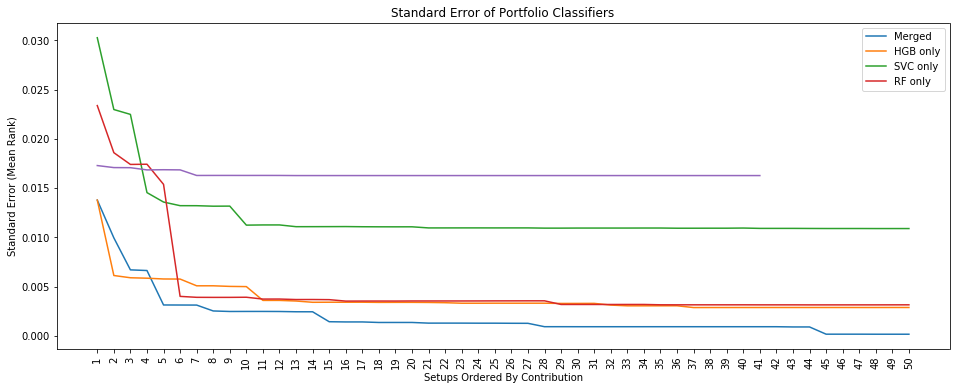

In [72]:
ax1 = pd.Series(pp_merged_sem_rank[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_hgb_sem_rank[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_svc_sem_rank[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_rf_sem_rank[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_lr_sem_rank[0:50]).plot(figsize = (16,6), xticks=range(50))


ax1.set_xticklabels(labels=range(1,51), rotation = 90)
ax1.legend(['Merged','HGB only','SVC only', 'RF only'])
ax1.set_yscale('linear')
ax1.set_ylabel('Standard Error (Mean Rank)')
ax1.set_xlabel('Setups Ordered By Contribution')
ax1.set_title('Standard Error of Portfolio Classifiers')
;


# Get model condigurations

## Merged portfolio by rank

In [73]:
# get ensemble of X setups
setup_list_merged_rank = sub_opt(evals_merged_rank, 31, criterion='mean', ranking='min')
print(setup_list_merged_rank)

[8166999, 8261540, 8255634, 8262236, 8275916, 8255712, 8155841, 8158225, 8261570, 8255823, 8157123, 8255729, 8155977, 8255724, 8155253, 8261524, 8255719, 8255723, 8255687, 8156997, 8166725, 8157545, 8255596, 8157452, 8255610, 8157501, 8261785, 8255830, 8168865, 8261573, 8154288, 8255920]


In [74]:
# get ensemble of X setups
setup_list_merged_rank = sub_opt(evals_merged_rank, 31, criterion='mean', ranking='min')
print(setup_list_merged_rank)

[8166999, 8261540, 8255634, 8262236, 8275916, 8255712, 8155841, 8158225, 8261570, 8255823, 8157123, 8255729, 8155977, 8255724, 8155253, 8261524, 8255719, 8255723, 8255687, 8156997, 8166725, 8157545, 8255596, 8157452, 8255610, 8157501, 8261785, 8255830, 8168865, 8261573, 8154288, 8255920]


In [75]:
algorithms = []
for i in setup_list_merged_rank:
    clf = openml.setups.initialize_model(i)[-1]
    clf_str = str(type(clf)).split('.')[-1].strip(string.punctuation)
    algorithms.append(clf_str)

In [76]:
pd.DataFrame(algorithms)

,0
0,HistGradientBoostingClassifier
1,RandomForestClassifier
2,SVC
3,RandomForestClassifier
4,LogisticRegression
5,SVC
6,HistGradientBoostingClassifier
7,HistGradientBoostingClassifier
8,RandomForestClassifier
9,SVC


In [77]:
pd.Series(algorithms).value_counts()


HistGradientBoostingClassifier    13
SVC                               12
RandomForestClassifier             6
LogisticRegression                 1
dtype: int64

In [78]:
default_params = ("criterion='gini'", 'max_depth=None', "max_features='auto'",
                  'max_leaf_nodes=None', 'min_impurity_split=None', 'min_samples_leaf=1',
                  'min_samples_split=2', 'min_weight_fraction_leaf=0.0', "n_estimators='warn'",
                  
                  'l2_regularization=0.0', 'learning_rate=0.1', "loss='auto'", 'max_bins=255', 
                  'max_depth=None', 'max_iter=100', 'max_leaf_nodes=31', 'min_samples_leaf=20',
                  
                  'C=1.0', 'coef0=0.0', 'degree=3', "gamma='auto'", "kernel='rbf",
                  
                  "penalty='l2'", 'C=1.0', 'fit_intercept=True', 'intercept_scaling=1',
                 'class_weight=None', "solver='lbfgs'", "multi_class='auto'", 'l1_ratio=None')

In [85]:
counter = 1
for i in setup_list_merged_rank:
    
    clf = openml.setups.initialize_model(i)[-1]
    
    if 'Hist' in str(type(clf)):
        params=['l2_regularization='+str(clf.get_params()['l2_regularization']),
                 'learning_rate='+str(clf.get_params()['learning_rate']),
                 "loss="+"'"+str(clf.get_params()['loss'])+"'",
                 'max_bins='+str(clf.get_params()['max_bins']),
                 'max_depth='+str(clf.get_params()['max_depth']),
                 'max_iter='+str(clf.get_params()['max_iter']),
                 'max_leaf_nodes='+str(clf.get_params()['max_leaf_nodes']),
                 'min_samples_leaf='+str(clf.get_params()['min_samples_leaf'])]

        params_clean = ", ".join([i for i in params if i not in default_params])
        print("HistGradientBoostingClassifier("+params_clean+"),")
        
    elif 'SVC' in str(type(clf)):
        params=['C='+str(clf.get_params()['C']),
             'coef0='+str(clf.get_params()['coef0']),
             'degree='+str(clf.get_params()['degree']),
             'gamma='+str(clf.get_params()['gamma']),
             'kernel='+"'"+str(clf.get_params()['kernel'])+"'"]

        params_clean = ", ".join([i for i in params if i not in default_params])
        print("SVC("+params_clean+"),")
    
    elif 'Random' in str(type(clf)):
        params=['criterion='+"'"+str(clf.get_params()['criterion'])+"'",
                'max_depth='+str(clf.get_params()['max_depth']),
                'max_features='+str(clf.get_params()['max_features']),
                'max_leaf_nodes='+str(clf.get_params()['max_leaf_nodes']),
                'min_impurity_split='+str(clf.get_params()['min_impurity_split']),
                'min_samples_leaf='+str(clf.get_params()['min_samples_leaf']),
                'min_samples_split='+str(clf.get_params()['min_samples_split']),
                'min_weight_fraction_leaf='+str(clf.get_params()['min_weight_fraction_leaf']),
                'n_estimators='+str(clf.get_params()['n_estimators'])]
        params_clean = ", ".join([i for i in params if i not in default_params])
        print("RandomForestClassifier("+params_clean+"),")
        
    elif 'Logistic' in str(type(clf)):
        params=['C='+str(clf.get_params()['C']),
                'fit_intercept='+str(clf.get_params()['fit_intercept']),
                'intercept_scaling='+str(clf.get_params()['intercept_scaling']),
                'max_iter='+str(clf.get_params()['max_iter']),
                'class_weight='+str(clf.get_params()['class_weight']),
                'l1_ratio='+str(clf.get_params()['l1_ratio']),
                'solver='+"'"+str(clf.get_params()['solver'])+"'",
                'penalty='+"'"+str(clf.get_params()['penalty'])+"'"               
               ]
        
        params_clean = ", ".join([i for i in params if i not in default_params])
        print("LogisticRegression("+params_clean+"),")

    print()
    counter += 1

HistGradientBoostingClassifier(l2_regularization=1e-06, max_bins=256, max_iter=200, max_leaf_nodes=128, min_samples_leaf=50),

RandomForestClassifier(criterion='entropy', max_features=0.32778941525789984, min_samples_split=5, n_estimators=300),

SVC(C=52.368035023140784, gamma=0.008051730038808798, kernel='rbf'),

RandomForestClassifier(criterion='entropy', max_features=0.07198156955074353, min_samples_split=6, n_estimators=500),

LogisticRegression(C=0.1, max_iter=10000),

SVC(C=170.5572031055097, coef0=0.7430320055311159, degree=2, gamma=0.049727598083142026, kernel='poly'),

HistGradientBoostingClassifier(l2_regularization=0.001, max_bins=256, max_depth=18, max_iter=450, max_leaf_nodes=64, min_samples_leaf=9),

HistGradientBoostingClassifier(l2_regularization=100.0, max_bins=256, max_depth=17, max_iter=200, max_leaf_nodes=128, min_samples_leaf=37),

RandomForestClassifier(criterion='entropy', max_features=0.27977761318292416, n_estimators=500),

SVC(C=2854.2115055717222, coef0=0.909

## HGB portfolio by rank

In [90]:
setup_list_hgb_rank = sub_opt(evals_hgb_rank, 31, criterion='mean', ranking='min')
print(setup_list_hgb_rank)

[8166999, 8158101, 8154931, 8158087, 8156960, 8156260, 8155322, 8155006, 8155405, 8154535, 8154370, 8155748, 8154465, 8155137, 8154742, 8155757, 8156853, 8157543, 8155577, 8156931, 8154713, 8157985, 8154107, 8155061, 8155841, 8154704, 8157910, 8154927, 8154835, 8157828, 8155196, 8156475]


In [91]:
counter = 1
for i in setup_list_hgb_rank:

    clf = openml.setups.initialize_model(i)[-1]
    
    params=['l2_regularization='+str(clf.get_params()['l2_regularization']),
         'learning_rate='+str(clf.get_params()['learning_rate']),
         "loss="+"'"+str(clf.get_params()['loss'])+"'",
         'max_bins='+str(clf.get_params()['max_bins']),
         'max_depth='+str(clf.get_params()['max_depth']),
         'max_iter='+str(clf.get_params()['max_iter']),
         'max_leaf_nodes='+str(clf.get_params()['max_leaf_nodes']),
         'min_samples_leaf='+str(clf.get_params()['min_samples_leaf'])]
    
    params_clean = ", ".join([i for i in params if i not in default_params])
    print("HistGradientBoostingClassifier("+params_clean+"),")
    print()
    
    counter += 1

HistGradientBoostingClassifier(l2_regularization=1e-06, max_bins=256, max_iter=200, max_leaf_nodes=128, min_samples_leaf=50),

HistGradientBoostingClassifier(l2_regularization=1.0, max_bins=64, max_depth=5, max_leaf_nodes=4),

HistGradientBoostingClassifier(l2_regularization=1.0, max_bins=64, max_depth=18, max_iter=350, max_leaf_nodes=32, min_samples_leaf=7),

HistGradientBoostingClassifier(l2_regularization=1e-07, max_bins=16, max_depth=19, max_iter=500, max_leaf_nodes=8, min_samples_leaf=27),

HistGradientBoostingClassifier(l2_regularization=10.0, max_bins=256, max_depth=16, max_leaf_nodes=128, min_samples_leaf=8),

HistGradientBoostingClassifier(l2_regularization=1e-07, max_bins=256, max_depth=16, max_iter=350, max_leaf_nodes=128, min_samples_leaf=13),

HistGradientBoostingClassifier(l2_regularization=10.0, max_bins=8, max_depth=20, max_iter=150, max_leaf_nodes=4, min_samples_leaf=13),

HistGradientBoostingClassifier(l2_regularization=1e-07, max_bins=16, max_depth=3, max_iter=350, m

## SVC portfolio by rank

In [92]:
setup_list_svc_rank = sub_opt(evals_svc_rank, 31, criterion='mean', ranking='min')
print(setup_list_svc_rank)

[8255634, 8255569, 8255546, 8255660, 8255687, 8255559, 8255619, 8255617, 8255598, 8255616, 8256151, 8255513, 8255924, 8255623, 8255596, 8255829, 8255732, 8255878, 8255610, 8255853, 8255939, 8255661, 8255612, 8255630, 8255808, 8255861, 8255640, 8255556, 8255862, 8255723, 8255951, 8255743]


In [93]:
counter = 1
for i in setup_list_svc_rank:
    
    clf = openml.setups.initialize_model(i)[-1]

    params=['C='+str(clf.get_params()['C']),
         'coef0='+str(clf.get_params()['coef0']),
         'degree='+str(clf.get_params()['degree']),
         'gamma='+str(clf.get_params()['gamma']),
         'kernel='+"'"+str(clf.get_params()['kernel'])+"'"]
    
    params_clean = ", ".join([i for i in params if i not in default_params])
    print("SVC("+params_clean+"),")
    print()
    
    counter += 1

SVC(C=52.368035023140784, gamma=0.008051730038808798, kernel='rbf'),

SVC(C=149.07622270551335, gamma=0.05610768111553853, kernel='rbf'),

SVC(C=1.68536554317688, coef0=0.2168646578884883, gamma=0.0008080068502590277, kernel='rbf'),

SVC(C=81.8664880584341, coef0=0.1339044447397313, degree=4, gamma=0.6339071538529285, kernel='rbf'),

SVC(C=1.799125831143992, coef0=0.7926565732345652, gamma=0.01858955180141993, kernel='poly'),

SVC(C=55762.3529353618, coef0=-0.8056114085510306, gamma=3.187772482265977e-05, kernel='sigmoid'),

SVC(C=34.18479740302528, coef0=0.465809282171058, gamma=0.025017141595224057, kernel='rbf'),

SVC(C=4.104647380564808, coef0=-0.724712336449596, degree=5, gamma=0.2926981232494074, kernel='rbf'),

SVC(C=0.42681252219264904, coef0=0.23495235580748663, degree=4, gamma=0.0419665675168468, kernel='rbf'),

SVC(C=0.38559962233936546, coef0=0.08722972305625087, gamma=7.521110541330819, kernel='rbf'),

SVC(C=128.0, gamma=0.03125, kernel='rbf'),

SVC(C=1.0827206202000408, g

## RF portfolio by rank

In [94]:
setup_list_rf_rank = sub_opt(evals_rf_rank, 31, criterion='mean', ranking='min')
print(setup_list_rf_rank)

[8261522, 8261928, 8262150, 8261754, 8262261, 8261901, 8262089, 8261708, 8261674, 8261576, 8261588, 8261862, 8261806, 8261567, 8261602, 8261740, 8261759, 8261817, 8261710, 8261524, 8261896, 8261514, 8261688, 8261583, 8262236, 8262053, 8261778, 8262023, 8261769, 8261558, 8261787, 8261968]


In [95]:
counter = 1

for i in setup_list_rf_rank:
    
    clf = openml.setups.initialize_model(i)[-1]

    params=['criterion='+"'"+str(clf.get_params()['criterion'])+"'",
            'max_depth='+str(clf.get_params()['max_depth']),
            'max_features='+str(clf.get_params()['max_features']),
            'max_leaf_nodes='+str(clf.get_params()['max_leaf_nodes']),
            'min_impurity_split='+str(clf.get_params()['min_impurity_split']),
            'min_samples_leaf='+str(clf.get_params()['min_samples_leaf']),
            'min_samples_split='+str(clf.get_params()['min_samples_split']),
            'min_weight_fraction_leaf='+str(clf.get_params()['min_weight_fraction_leaf']),
            'n_estimators='+str(clf.get_params()['n_estimators'])]
    params_clean = ", ".join([i for i in params if i not in default_params])
    print("RandomForestClassifier("+params_clean+"),")
    print()
    counter += 1

RandomForestClassifier(criterion='entropy', max_features=0.13891783454814322, min_samples_leaf=2, min_samples_split=9, n_estimators=300),

RandomForestClassifier(max_features=0.050069426976632525, min_samples_split=3, n_estimators=500),

RandomForestClassifier(criterion='entropy', max_features=0.38146409165028106, min_samples_split=12, n_estimators=300),

RandomForestClassifier(criterion='entropy', max_features=0.20254434685778855, min_samples_split=3, n_estimators=500),

RandomForestClassifier(max_features=0.05946371474549883, n_estimators=300),

RandomForestClassifier(criterion='entropy', max_features=0.4203242802359065, min_samples_split=9, n_estimators=100),

RandomForestClassifier(criterion='entropy', max_features=0.8014260101515722, min_samples_leaf=6, min_samples_split=18, n_estimators=300),

RandomForestClassifier(criterion='entropy', max_features=0.17540145080676417, n_estimators=300),

RandomForestClassifier(max_features=0.12496709200924094, n_estimators=500),

RandomForestCl

## LR portfolio by rank

In [96]:
setup_list_lr_rank = sub_opt(evals_lr_rank, 31, criterion='mean', ranking='min')
print(setup_list_lr_rank)

[8275905, 8275903, 8275908, 8275904, 8275906, 8275912, 8275574, 8275915, 8275907, 8275632, 8275575, 8275614, 8275920, 8275917, 8275629, 8275623, 8275573, 8275624, 8275625, 8275619, 8275616, 8275627, 8275628, 8275573, 8275573, 8275573, 8275573, 8275573, 8275573, 8275573, 8275573, 8275573]


In [100]:
counter = 1

for i in setup_list_lr_rank[0:16]:
    
    clf = openml.setups.initialize_model(i)[-1]

    params=['C='+str(clf.get_params()['C']),
            'fit_intercept='+str(clf.get_params()['fit_intercept']),
            'intercept_scaling='+str(clf.get_params()['intercept_scaling']),
            'max_iter='+str(clf.get_params()['max_iter']),
            'class_weight='+str(clf.get_params()['class_weight']),
            'l1_ratio='+str(clf.get_params()['l1_ratio']),
            'solver='+"'"+str(clf.get_params()['solver'])+"'",
            'penalty='+"'"+str(clf.get_params()['penalty'])+"'"]
        
    params_clean = ", ".join([i for i in params if i not in default_params])
    print("LogisticRegression("+params_clean+"),")
    print()
    counter += 1

LogisticRegression(C=1, max_iter=10000),

LogisticRegression(C=0.1, max_iter=10000),

LogisticRegression(C=10, max_iter=10000),

LogisticRegression(C=0.01, max_iter=10000),

LogisticRegression(C=10, max_iter=10000),

LogisticRegression(C=224.662208931, max_iter=785, solver='liblinear'),

LogisticRegression(C=0.001, max_iter=10000),

LogisticRegression(C=0.165918932915, max_iter=57, solver='liblinear'),

LogisticRegression(C=100000.0, max_iter=724, solver='liblinear'),

LogisticRegression(C=15.0, solver='liblinear'),

LogisticRegression(C=0.01, max_iter=10000),

LogisticRegression(solver='liblinear'),

LogisticRegression(C=15.0, solver='liblinear'),

LogisticRegression(C=0.01, solver='liblinear'),

LogisticRegression(C=500),

LogisticRegression(C=224.662208931, max_iter=785, solver='liblinear'),



# Compare portfolios

In [124]:
task_perf_merged = evals_wide_merged.loc[setup_list_merged_rank,:].max()
task_perf_hgb = evals_wide_merged.loc[setup_list_hgb_rank,:].max()
task_perf_svc = evals_wide_merged.loc[setup_list_svc_rank,:].max()
task_perf_rf = evals_wide_merged.loc[setup_list_rf_rank,:].max()
task_perf_lr = evals_wide_merged.loc[setup_list_lr_rank,:].max()


In [125]:
task_perf_comp = pd.concat([task_perf_merged, task_perf_hgb, task_perf_svc, task_perf_rf, task_perf_lr], axis=1)

In [126]:
task_perf_comp = task_perf_comp.rename(columns={0: 'merged', 1: 'hgb', 2: 'svc', 3: 'rf', 4: 'lr'})

In [127]:
task_perf_comp = task_perf_comp.fillna(0.5)

In [128]:
task_perf_comp.describe()

,merged,hgb,svc,rf,lr
count,66.000000,66.000000,66.000000,66.000000,66.000000
mean,0.932879,0.929802,0.918091,0.928742,0.899324
std,0.101885,0.104123,0.112255,0.102581,0.116877
min,0.530643,0.529776,0.530643,0.528378,0.530304
25%,0.924426,0.919486,0.869976,0.918446,0.832047
50%,0.984119,0.978840,0.969768,0.967258,0.950915
75%,0.999437,0.998424,0.999319,0.998335,0.994504
max,1.000000,1.000000,1.000000,0.999969,0.999987


In [129]:
task_perf_comp_rank = task_perf_comp.rank(axis=1, method='min', ascending=False)

In [130]:
task_perf_comp_rank.describe()

,merged,hgb,svc,rf,lr
count,66.000000,66.000000,66.000000,66.000000,66.000000
mean,1.333333,2.606061,2.863636,3.257576,4.500000
std,0.535891,1.251200,1.391030,1.231767,0.863802
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.250000,1.000000,3.000000,4.000000
50%,1.000000,3.000000,3.000000,3.000000,5.000000
75%,2.000000,4.000000,4.000000,4.000000,5.000000
max,3.000000,5.000000,5.000000,5.000000,5.000000


In [131]:
task_perf_comp_rank.melt()

,variable,value
0,merged,1.0
1,merged,1.0
2,merged,1.0
3,merged,1.0
4,merged,2.0
...,...,...
325,lr,5.0
326,lr,5.0
327,lr,3.0
328,lr,5.0


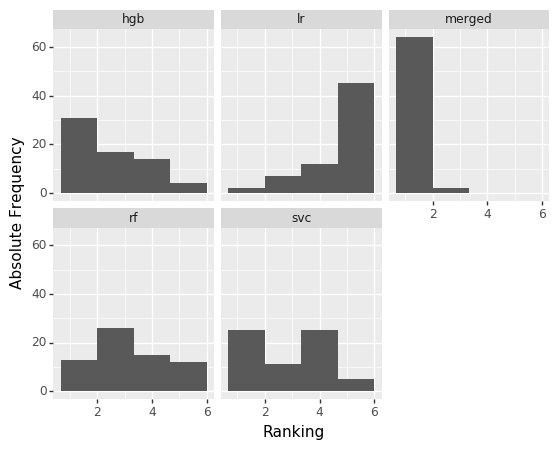

<ggplot: (-9223372029286988263)>

In [132]:
(ggplot(task_perf_comp_rank.melt()) +
 aes(x='value') + 
 geom_histogram(bins=4) +
 facet_wrap('variable') +
 xlab('Ranking') +
 ylab('Absolute Frequency')
)

In [133]:
rank_mean = task_perf_comp_rank.mean()
rank_sem = task_perf_comp_rank.sem()

Text(0, 0.5, 'Mean rank')

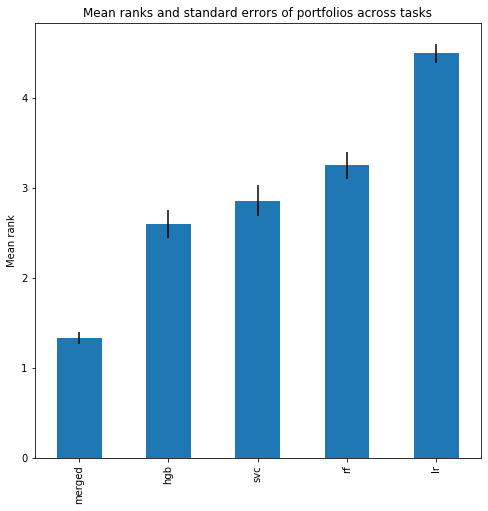

In [134]:
ax = rank_mean.plot(kind='bar', yerr=rank_sem, figsize=(8,8))
ax.set_title('Mean ranks and standard errors of portfolios across tasks')
ax.set_ylabel('Mean rank')

In [136]:
task_perf_comp_rank.sem()

merged    0.065964
hgb       0.154012
svc       0.171224
rf        0.151620
lr        0.106327
dtype: float64

In [137]:
AUC_mean = task_perf_comp.mean()
AUC_sem = task_perf_comp.sem()

Text(0, 0.5, 'Mean AUC')

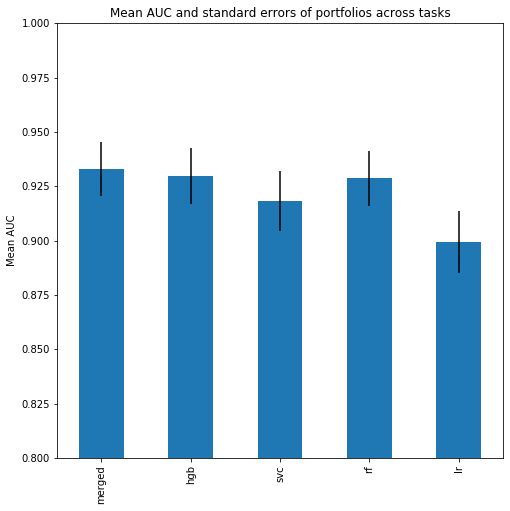

In [138]:
ax = AUC_mean.plot(kind='bar', yerr=AUC_sem, figsize=(8,8), ylim=(0.8,1))
ax.set_title('Mean AUC and standard errors of portfolios across tasks')
ax.set_ylabel('Mean AUC')